In [1]:
#| default_exp preprocessing.lesson17

# Lesson17
> Reproducing lesson 17

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

In [3]:
#| export
from cv_tools.core import *
from fastcore.all import *


In [4]:
#| export
import sys, traceback, gc
import matplotlib.pyplot as plt
from datasets import load_dataset


In [5]:
#| export
import torch
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)


In [6]:
#| export
import logging
logging.disable(logging.WARNING)

In [7]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [8]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [9]:
#| export
def clean_mem(torch_:bool=True):
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    if torch_: torch.cuda.empty_cache()

In [10]:
clean_mem()

# Get data

In [11]:
#| exporti
from fastai_course22p2.preprocessing.lesson16_after_lesson import *
from fastai_course22p2.preprocessing.lesson16_second_part import *

In [12]:
set_seed(42)

In [45]:
#| export
@inplace
def transformi(b): b['image'] = TF.to_tensor(b['image'])


In [46]:
dls = prep_data()

In [47]:
x, y = next(iter(dls.train))
x.shape, y[:10]


(torch.Size([1024, 1, 28, 28]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [48]:
#| export
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = def_device

In [49]:
#| export
def get_model():
	return nn.Sequential(
		conv(1, 8), 
		conv(8, 16), 
		conv(16, 32), 
		conv(32, 64), 
		conv(64,10, act=False), 
		nn.Flatten()).to(device)


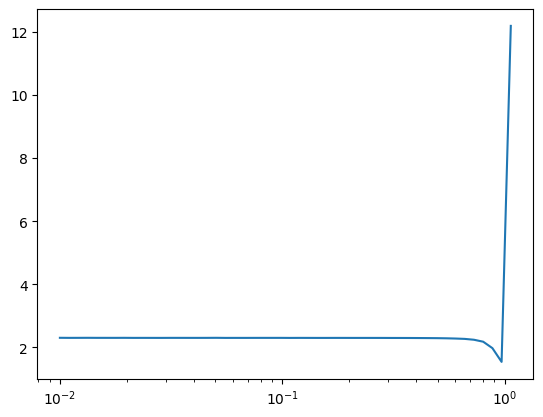

In [50]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
MomentumLearner(
	get_model(), 
    dls, 
    loss_func=F.cross_entropy, 
    cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [51]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(
	get_model(), 
	dls,
    loss_func=F.cross_entropy,lr=0.2, cbs=cbs)

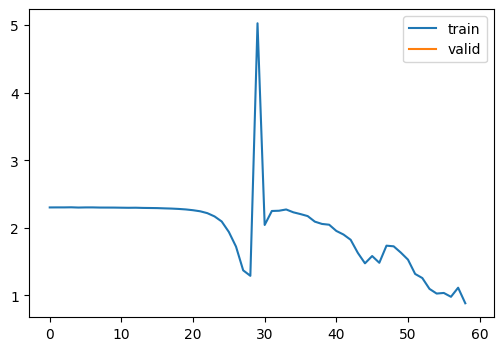

In [52]:
learn.fit(1)

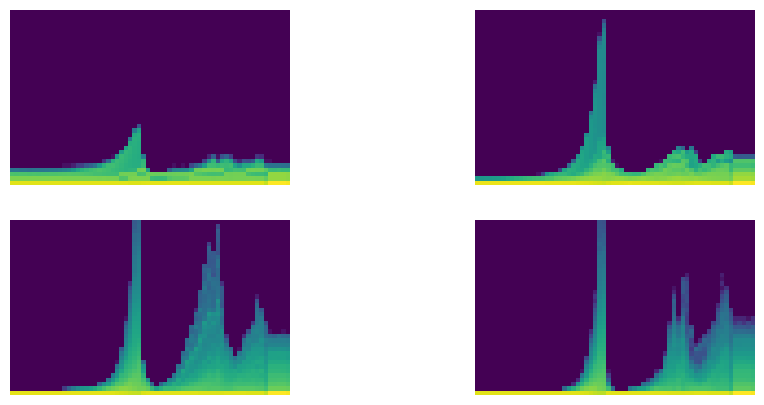

In [53]:
astats.color_dim()

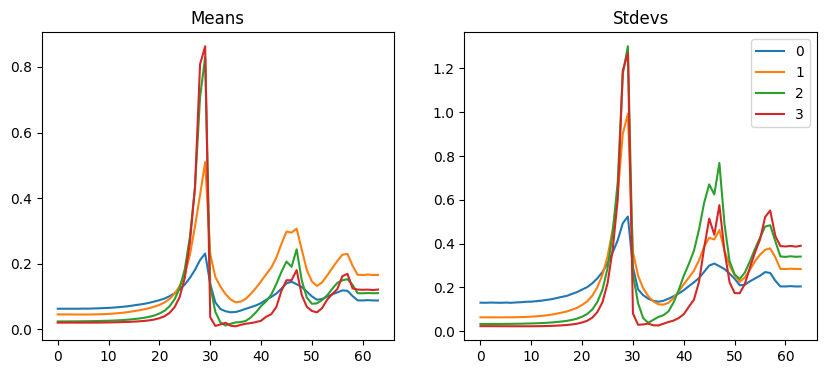

In [54]:
astats.plot_stats()

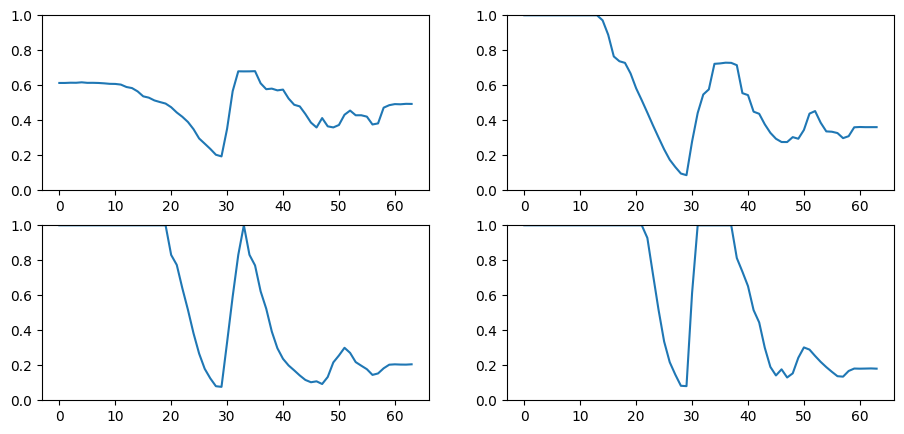

In [55]:
astats.dead_chart()

# Initialization

### Kaiming He Initialization

In [56]:
#| export
from math import sqrt

In [57]:
x = torch.randn(200,100)
y = torch.randn(200)

In [58]:
w1 = torch.randn(100,50)/sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1)/sqrt(50)
b2 = torch.zeros(1)

In [59]:
def lin(x, w, b): return x@w + b

In [60]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(-0.01), tensor(1.00))

In [61]:
def relu(x): return x.clamp_min(0)
l2 = relu(lin(x, w1, b1))
l2.mean(), l2.std()


(tensor(0.39), tensor(0.58))

In [62]:
x = torch.randn(200,100)
w1 = torch.randn(100,50)*sqrt(2/100)
l1 = lin(x, w1, b1)
l1.mean(), l1.std()


(tensor(0.00), tensor(1.42))

> `RelU` is changing mean 0 and std 1

In [63]:
x = torch.randn(200,100)
w1 = torch.randn(100,50)*sqrt(2/100)
l1 = relu(lin(x, w1, b1))
l1.mean(), l1.std()


(tensor(0.55), tensor(0.83))

### Apply an init function

In [64]:
model = get_model()
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [65]:
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [66]:
#| export
def init_weights(m):
	if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Conv3d)):
		nn.init.kaiming_normal_(m.weight)
		


In [67]:
model.apply(init_weights);


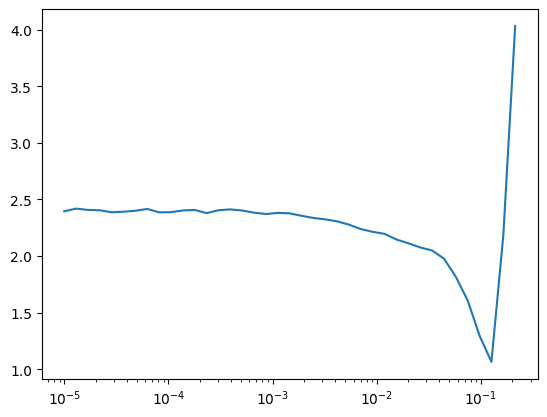

In [68]:
MomentumLearner(
    model, dls, loss_func=F.cross_entropy, cbs=[DeviceCB()]).lr_find()

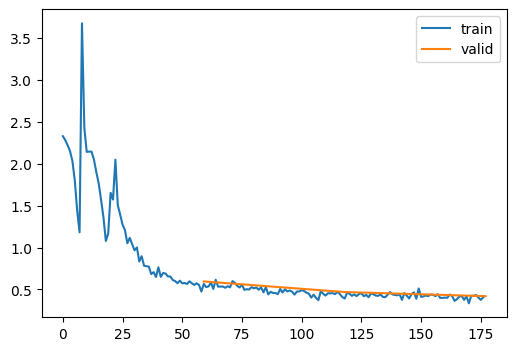

In [69]:
set_seed(42)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(
    get_model().apply(init_weights), 
    dls, 
    loss_func=F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)



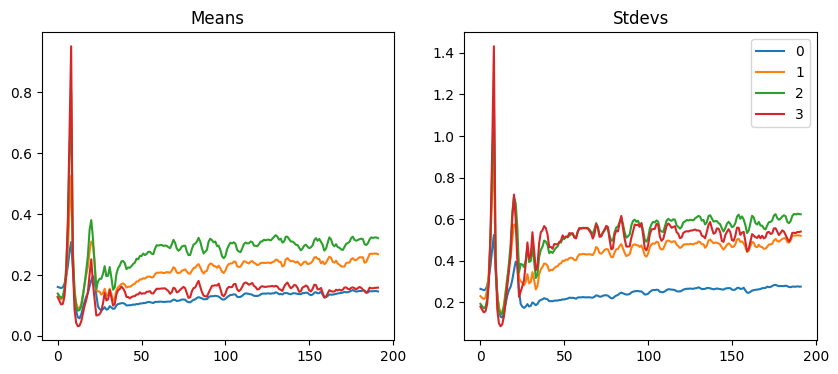

In [70]:
astats.plot_stats()

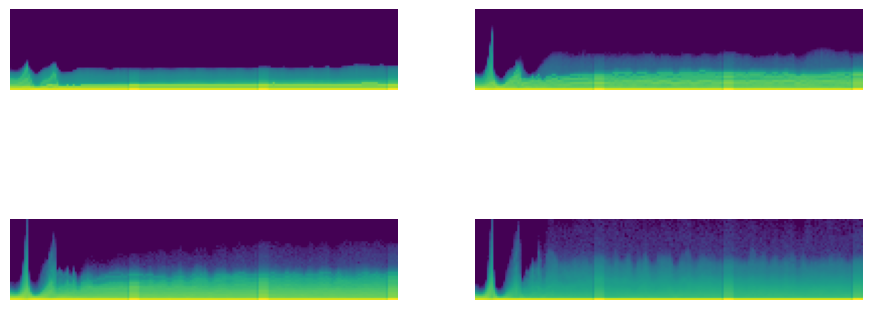

In [71]:
astats.color_dim()

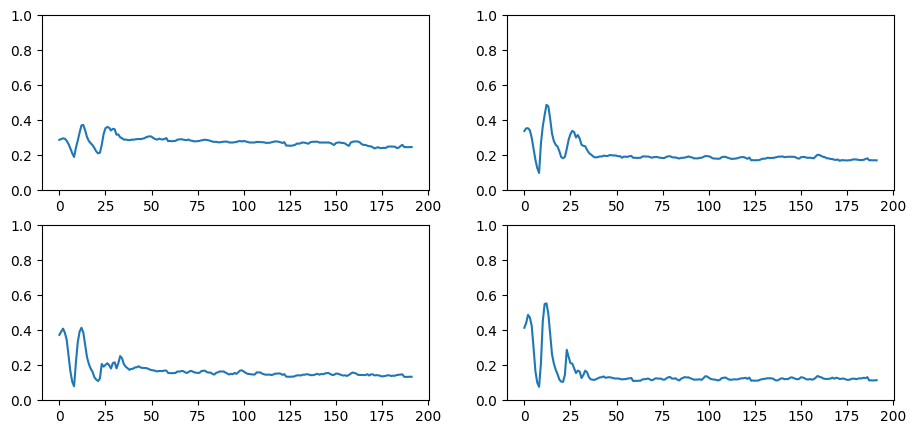

In [72]:
astats.dead_chart()

# Input normalization


In [73]:
xb, yb = next(iter(dls.train))
xb.shape, yb.shape
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

In [13]:
#| export
class BatchTransformCB(Callback):
	def __init__(
			self, tfm,
			on_train=True, on_val=True):
		store_attr()

	def before_batch(self, learn):
		if (self.on_train and learn.training) or (self.on_val and not learn.training):
			learn.batch = self.tfm(learn.batch)

In [14]:
#| export
def _norm(batch):
	return (batch[0] - xmean ) / xstd, batch[1]

norm = BatchTransformCB(_norm)

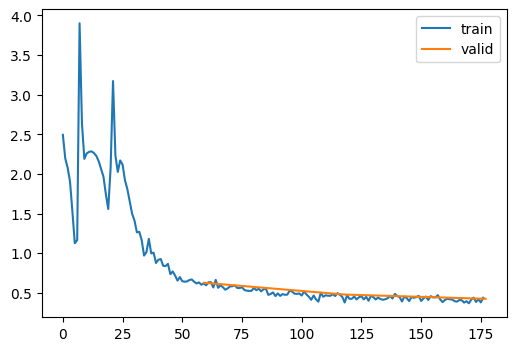

In [76]:
set_seed(42)
#metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs= [
    DeviceCB(), 
    metrics, 
    ProgressCB(plot=True), 
    astats]
learn = MomentumLearner(
    get_model().apply(init_weights), 
    dls, 
    loss_func=F.cross_entropy, 
	lr=0.2,
    cbs=cbs+[norm])
learn.fit(3)


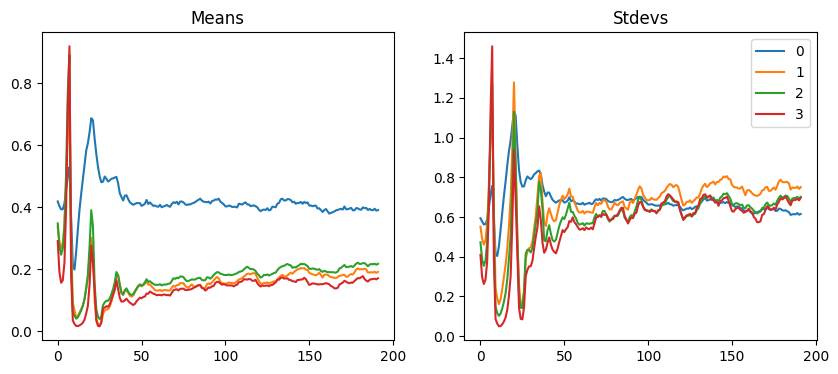

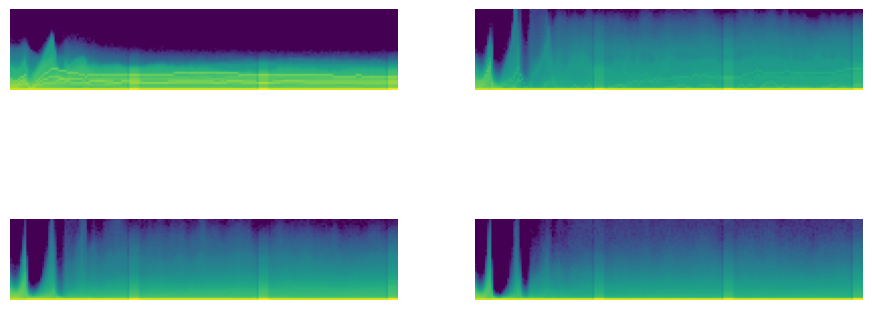

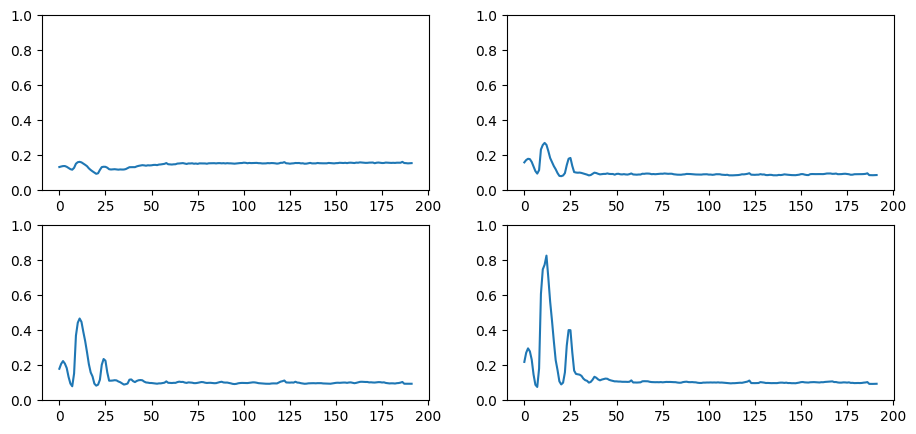

In [77]:
astats.plot_stats()
astats.color_dim()
astats.dead_chart()


> Apply this normalization to whole dataset

In [18]:
#| export
xmean, xstd = 0.29, 0.35
@inplace
def transformi_n(b): b['image'] = [(TF.to_tensor(o) -xmean)/xstd for o in b['image']]


In [19]:
#| export
def prep_data_n():
	dsd = load_dataset('fashion_mnist')
	tds = dsd.with_transform(transformi_n)
	dls = DataLoaders.from_dd(tds, batch_size=1024, num_workers=0)

	return dls


In [21]:
dls_n = prep_data_n()
xb, yb = next(iter(dls_n.train))
xb.mean(), xb.std()

(tensor(-0.02), tensor(1.00))

## General RelU

> Now its better but still our model after Relu is not mean 0 and std 1
- Because ReLu makes everything positive

In [22]:
#| export
class GeneralRelu(nn.Module):
	def __init__(self, leak=None, sub=None, maxv=None): 
		super().__init__()
		store_attr()
	def forward(self, x):
		x = F.leaky_relu(x, self.leak) if self.leak else F.relu(x)
		if self.sub: x -= self.sub
		if self.maxv: x = x.clamp_max(self.maxv)
		return x



In [23]:
#| export
def plot_func(f, start=-5, end=5, n=100):
	x = torch.linspace(start, end, n)
	y = f(x)
	plt.plot(x, y)
	plt.grid(True, which='both', ls='--')
	plt.axhline(0, color='k', linewidth=0.7)
	plt.axvline(0, color='k', linewidth=0.7)


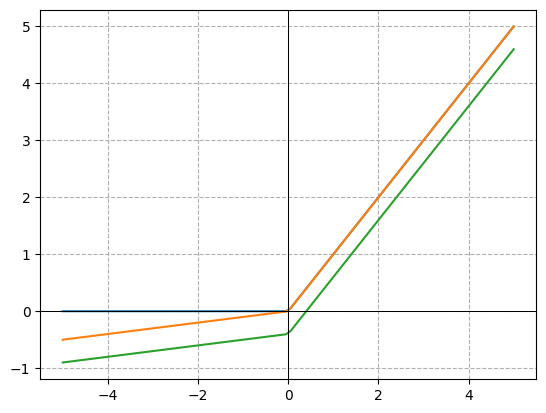

In [24]:

plot_func(lambda x: F.relu(x))
plot_func(lambda x: F.leaky_relu(x, 0.1))
plot_func(lambda x: GeneralRelu(leak=0.1, sub=.4)(x))


In [25]:
#| export
def conv_relu(ni, nf, ks=3, stride=2,act=nn.ReLU ):
	res = nn.Conv2d(
			ni, 
			nf, 
			kernel_size=ks, 
			stride=stride, 
			padding=ks//2)
	if act: res = nn.Sequential(res, act())
	return res



In [26]:
#| export
def get_model_(act=nn.ReLU, nfs=None):
	if nfs is None: nfs = [1, 8, 16, 32, 64]
	layers = [conv_relu(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
	return nn.Sequential(*layers, conv_relu(nfs[-1], 10, act=False), nn.Flatten()
					  ).to(def_device)



In [27]:
#| export
def init_weights(m, leaky=None):
	if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Conv3d)):
		nn.init.kaiming_normal_(m.weight,a=leaky)



In [28]:
dls_n = prep_data_n()
act_gr = partial(GeneralRelu, leak=0.1, sub=.4)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(risinstance(GeneralRelu))
iw = partial(init_weights, leaky=0.1)

model = get_model_(act=act_gr).apply(iw)

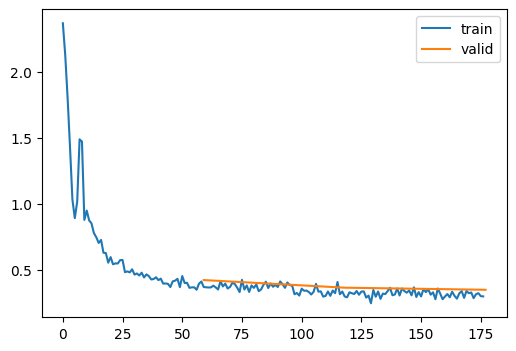

In [29]:
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
set_seed(42)
learn = MomentumLearner(
    model, 
    dls_n, 
    loss_func=F.cross_entropy, 
	lr=0.2,
    cbs=cbs)
learn.fit(3)


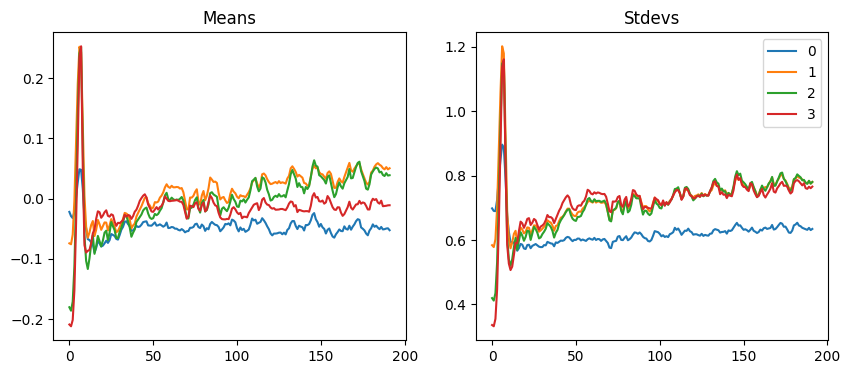

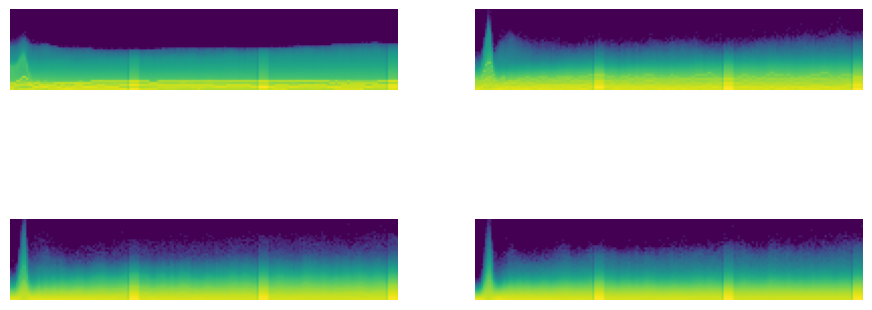

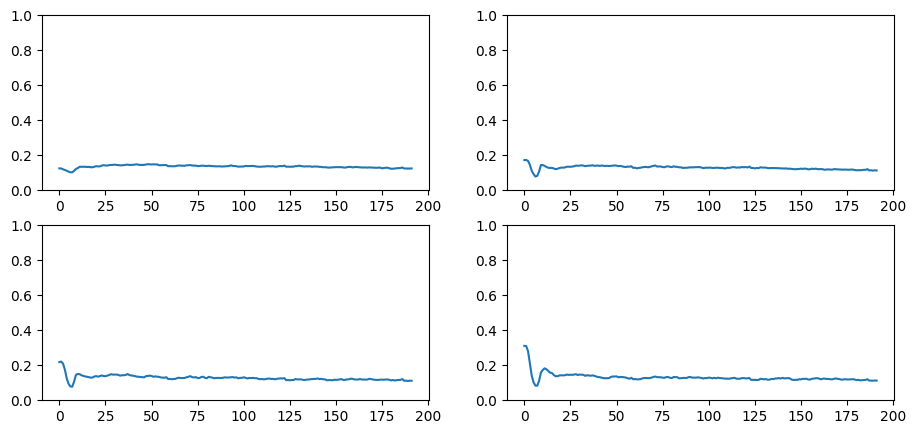

In [30]:


astats.plot_stats()
astats.color_dim()
astats.dead_chart()


# LSUV

> all you need is a good init

In [134]:
#| hide
import nbdev; nbdev.nbdev_export('05_preprocessing.lesson_17.ipynb')